<a href="https://colab.research.google.com/github/pritamsingh3202/Seamlessly_Integrating_a_Person_into_a_Scene/blob/main/Seamlessly_Integrating_a_Person_into_a_Scene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install rembg numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install rembg

In [ ]:
%pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 134GB/s]


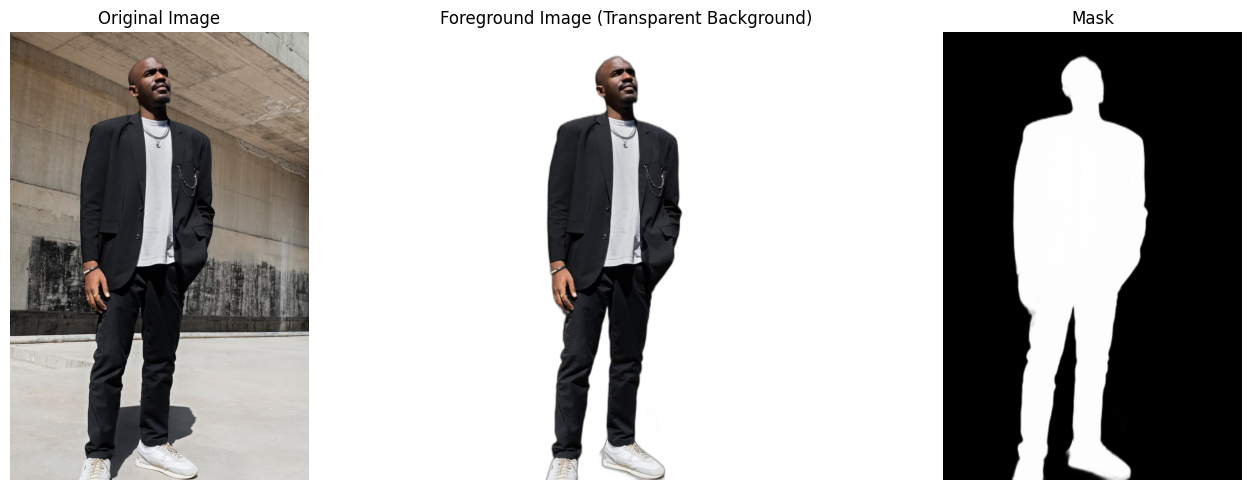

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from PIL import Image


person_image = Image.open('/content/FG1.jpg')
person_foreground = remove(person_image)
person_foreground = person_foreground.convert("RGBA")
alpha_channel = person_foreground.split()[-1]
person_mask = np.array(alpha_channel)
person_foreground.save('person_foreground.png')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(person_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(person_foreground)
axes[1].set_title('Foreground Image (Transparent Background)')
axes[1].axis('off')
axes[2].imshow(person_mask, cmap='gray')
axes[2].set_title('Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

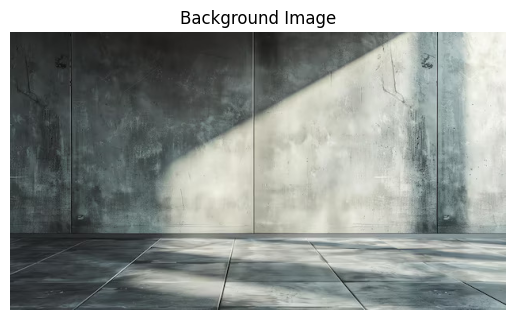

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

bg_image = Image.open('/content/bgr.jpg')
plt.imshow(bg_image)
plt.title('Background Image')
plt.axis('off')
plt.show()

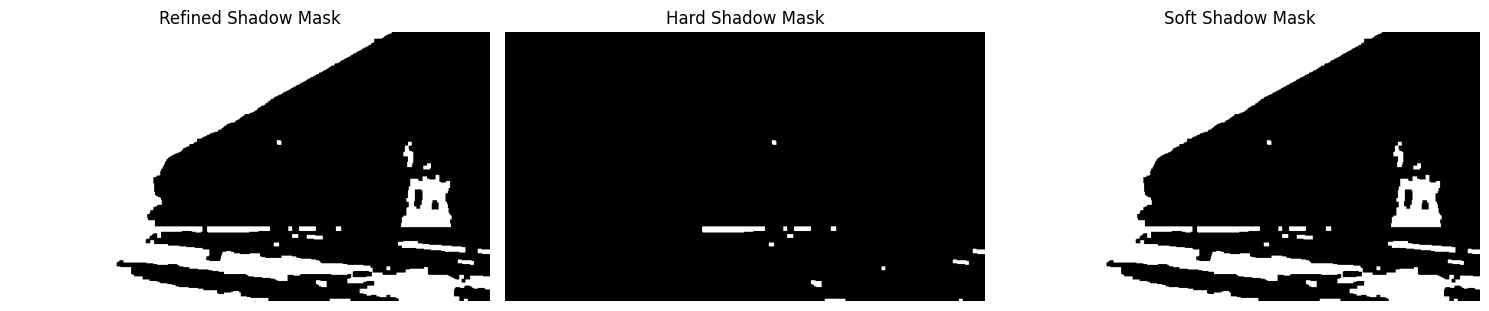

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


background_shadow_info = {}


bg_image_cv = cv2.imread('/content/bgr.jpg')
bg_image_gray = cv2.cvtColor(bg_image_cv, cv2.COLOR_BGR2GRAY)


shadow_mask_adaptive = cv2.adaptiveThreshold(bg_image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                             cv2.THRESH_BINARY_INV, 11, 2)

_, shadow_mask_otsu = cv2.threshold(bg_image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
combined_shadow_mask = cv2.bitwise_or(shadow_mask_adaptive, shadow_mask_otsu)

kernel = np.ones((5, 5), np.uint8)
refined_shadow_mask = cv2.morphologyEx(combined_shadow_mask, cv2.MORPH_OPEN, kernel)
refined_shadow_mask = cv2.morphologyEx(refined_shadow_mask, cv2.MORPH_CLOSE, kernel)

hard_shadow_mask = np.zeros_like(refined_shadow_mask)
soft_shadow_mask = np.zeros_like(refined_shadow_mask)


contours, _ = cv2.findContours(refined_shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:

    x, y, w, h = cv2.boundingRect(contour)
    roi_gray = bg_image_gray[y:y+h, x:x+w]

    if np.std(roi_gray) > 20:  #ADD. Threshold for soft shadow
        soft_shadow_mask[y:y+h, x:x+w] = refined_shadow_mask[y:y+h, x:x+w]
    else:
        hard_shadow_mask[y:y+h, x:x+w] = refined_shadow_mask[y:y+h, x:x+w]

# Store the shadow masks in the background_shadow_info dictionary
background_shadow_info['hard_shadow_mask'] = hard_shadow_mask
background_shadow_info['soft_shadow_mask'] = soft_shadow_mask


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(refined_shadow_mask, cmap='gray')
plt.title('Refined Shadow Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hard_shadow_mask, cmap='gray')
plt.title('Hard Shadow Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(soft_shadow_mask, cmap='gray')
plt.title('Soft Shadow Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

Estimated light direction: top-right


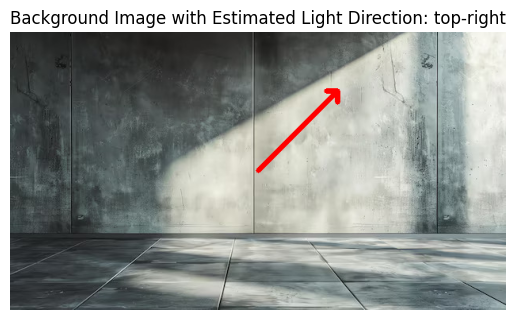

In [ ]:

# Initialize the dictionary to store light information
light_information = {}

light_direction = "Unknown"

# Find the centroid of the refined shadow mask
M = cv2.moments(refined_shadow_mask)
if M["m00"] != 0:
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    img_center_x, img_center_y = bg_image_gray.shape[1] // 2, bg_image_gray.shape[0] // 2


    light_direction = "top-right"


# Update the light_information dictionary
light_information['direction'] = light_direction

print(f"Estimated light direction: {light_direction}")
bg_image_with_direction = bg_image_cv.copy()

# Define arrow properties based on estimated direction
arrow_color = (0, 0, 255)
arrow_thickness = 5
arrow_length = 100

start_point = (img_center_x, img_center_y)
end_point = (img_center_x, img_center_y)

if light_direction == "bottom-right":
    end_point = (img_center_x + arrow_length, img_center_y + arrow_length)
elif light_direction == "top-right":
    end_point = (img_center_x + arrow_length, img_center_y - arrow_length)
elif light_direction == "bottom-left":
    end_point = (img_center_x - arrow_length, img_center_y + arrow_length)
elif light_direction == "top-left":
    end_point = (img_center_x - arrow_length, img_center_y - arrow_length)


cv2.arrowedLine(bg_image_with_direction, start_point, end_point, arrow_color, arrow_thickness)

plt.imshow(cv2.cvtColor(bg_image_with_direction, cv2.COLOR_BGR2RGB))
plt.title(f"Background Image with Estimated Light Direction: {light_direction}")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

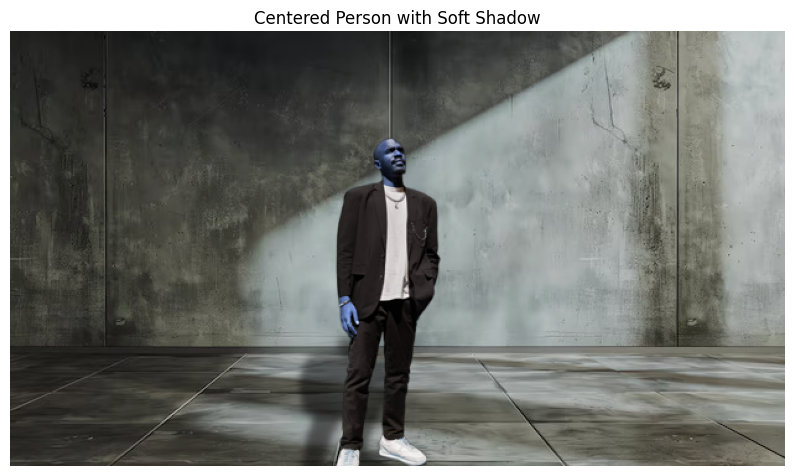

In [ ]:

light_information = {'direction': 'top-left'}

bg_image = Image.open("/content/bgr.jpg").convert("RGB")
person_foreground = Image.open("/content/person_foreground.png").convert("RGBA")


bg_image_np = np.array(bg_image)
bg_image_gray = cv2.cvtColor(bg_image_np, cv2.COLOR_RGB2GRAY)
bg_w, bg_h = bg_image.size

max_width = int(bg_w * 0.7)
max_height = int(bg_h * 0.8)

orig_width, orig_height = person_foreground.size

scale_w = max_width / orig_width
scale_h = max_height / orig_height
scale = min(scale_w, scale_h, 1.0)

person_width = max(1, int(orig_width * scale))
person_height = max(1, int(orig_height * scale))

person_foreground_resized = person_foreground.resize((person_width, person_height))

# Center position
start_x = (bg_w - person_width) // 2
start_y = (bg_h - person_height)
end_x = start_x + person_width
end_y = start_y + person_height

# Alpha mask
person_mask_resized = np.array(person_foreground_resized.split()[-1]) / 255.0

shadow_offset_x, shadow_offset_y = 0, 9
if light_information['direction'] == "top-left":
    shadow_offset_x, shadow_offset_y = 80, 80
elif light_information['direction'] == "top-right":
    shadow_offset_x, shadow_offset_y = -80, 80
elif light_information['direction'] == "bottom-left":
    shadow_offset_x, shadow_offset_y = 80, -80
elif light_information['direction'] == "bottom-right":
    shadow_offset_x, shadow_offset_y = -500, -500


shadow_offset_x = -30
shadow_offset_y =170

# Shadow position
shadow_roi_x_start = max(0, start_x + shadow_offset_x)
shadow_roi_y_start = max(0, start_y + shadow_offset_y)
shadow_roi_x_end = min(bg_w, shadow_roi_x_start + person_width)
shadow_roi_y_end = min(bg_h, shadow_roi_y_start + person_height)

shadow_region_width = shadow_roi_x_end - shadow_roi_x_start
shadow_region_height = shadow_roi_y_end - shadow_roi_y_start

stretched_width = int(shadow_region_width * 9.5)
stretched_height = shadow_region_height

# Resize mask for long horizontal shadow
person_mask_clipped = Image.fromarray((person_mask_resized * 255).astype(np.uint8)).resize(
    (stretched_width, stretched_height))

person_mask_resized_back = person_mask_clipped.resize((shadow_region_width, shadow_region_height))

shadow_mask_raw = np.array(person_mask_resized_back) / 255.0
shadow_mask_blurred = cv2.GaussianBlur(shadow_mask_raw, (15, 15), sigmaX=0, sigmaY=5)



shadow_mask = np.zeros_like(bg_image_gray, dtype=np.float32)
shadow_mask[shadow_roi_y_start:shadow_roi_y_end,
            shadow_roi_x_start:shadow_roi_x_end] = shadow_mask_blurred


shadow_color = (0, 0, 0)
shadow_alpha = 0.4
shadow_layer = np.zeros_like(bg_image_np, dtype=np.uint8)
shadow_layer[:] = shadow_color

alpha_shadow = shadow_mask[:, :, np.newaxis] * shadow_alpha
blended_image = (bg_image_np * (0.8 - alpha_shadow) + shadow_layer * alpha_shadow).astype(np.uint8)


final_start_x = max(0, start_x)
final_start_y = max(0, start_y)
final_end_x = min(blended_image.shape[1], end_x)
final_end_y = min(blended_image.shape[0], end_y)

clip_x_start = final_start_x - start_x
clip_y_start = final_start_y - start_y
clip_x_end = clip_x_start + (final_end_x - final_start_x)
clip_y_end = clip_y_start + (final_end_y - final_start_y)

person_rgb = np.array(person_foreground_resized.convert('RGB'))[clip_y_start:clip_y_end, clip_x_start:clip_x_end]
alpha_person = person_mask_resized[clip_y_start:clip_y_end, clip_x_start:clip_x_end][:, :, np.newaxis]

blended_roi = blended_image[final_start_y:final_end_y, final_start_x:final_end_x]
blended_roi = (blended_roi * (1 - alpha_person) + person_rgb * alpha_person).astype(np.uint8)
blended_image[final_start_y:final_end_y, final_start_x:final_end_x] = blended_roi

output_image = Image.fromarray(blended_image)
output_image = output_image.convert("RGB")
output_image.save("/content/seamless_output.jpg")

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_RGB2BGR))
plt.title("Centered Person with Soft Shadow")
plt.axis('off')
plt.show()